# 1. 음원 파일 찾기

저작권이 없는 Ai 무료 음원을 아래 사이트에서 다운로드
https://tunes.freepik.com/



# 2. 음원 비트 분리

UVR은 AI 학습된 모델을 통해 원하는 악기의 음역대를 추출할 수 있다.  
이를 활용해 No drums, Drums 파일을 추출 할 것.
타이밍 보존을 위해 **Wav** 포맷을 사용할 것

https://ultimatevocalremover.com/

![UVR](Images/UVR.png)


# 3 타이밍 추출
Drums 파일을 가지고 밑의 코드를 실행

코드는 다음의 단계를 수행하고 있음
 
1. RMS 구하기
2. Smoothing RMS
3. RMS DIFF 구하기
4. diff를 통해 Onset 판별하고 Chunk를 분리
5. 청크를 주파수 기준 K 클러스터링
6. 분리된 청크를 midi 및 Json 저장

# 4. 문제점

RMS 기반으로 분석하기 때문에 데시벨을 기준으로 Threshold를 하여 Onset을 판단하면
작은 소리 혹은 고주파 소리(에너지가 비교적 적음)는 검출하기 어려운 것을 확인하였다.

Dependency

In [7]:
# !pip install pydub
# !pip install librosa
# !pip install pretty_midi

아래의 파라미터를 변경하고 셀을 실행하여 결과를 확인.

In [8]:
path  = "GitIgnore"
file = "freepik-chiptune-moon-8_htdemucs_(Drums).wav"
tempo = 99
RMSThreshold =- 60
SmoothingIterations = 3
OnsetThreshold = 0.2 #(0~1)
BeatDistance_sec = 0.1 
PlotRange = (4,5)

In [9]:
import os
import Rhythm
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import stft
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import defaultdict
import pretty_midi
import json
from sklearn.preprocessing import StandardScaler

### Load Audio
fullpath = os.path.join(path,file)
Audio = Rhythm.GetAudioSegment(fullpath)
AudioArray = Rhythm.GetAudioArray(Audio)
time = librosa.frames_to_time(np.arange(len(AudioArray)), sr=Audio.frame_rate, hop_length=1)
Rhythm.PrintAudioInfo(Audio)

### CreateRms
audio_length = len(AudioArray)
Rms_frame_length = int(0.001 * Audio.frame_rate)
Rms_hop_length = Rms_frame_length//4
rms = librosa.feature.rms(y=AudioArray, frame_length=Rms_frame_length, hop_length=Rms_hop_length, center=True, pad_mode='constant')[0]
rms[rms <= RMSThreshold ]  = RMSThreshold

rms_time = librosa.frames_to_time(np.arange(len(rms)), sr=Audio.frame_rate, hop_length=Rms_hop_length)
print(f"RMS Params: frameLength{Rms_frame_length}, hop{Rms_hop_length}")

### Create RMS DB
rms_max = np.max(rms)
rms_normalized = (rms + 1e-12) / (rms_max + 1e-12)
rms_db = 20 * np.log10(rms_normalized + 1e-6) 
rms_db -= np.min(rms_normalized)

### Smoothing 
rms_db_fixed = rms_db.copy()
for i in range(1):
    uppderPoint = 10
    smoothingDistance_sec = 0.005
    frame_length = int(smoothingDistance_sec / (Rms_hop_length / Audio.frame_rate))
    hop_length = 1
    is_signal = Rhythm.Detect(rms_db_fixed,frame_length,Audio.frame_rate,hop_length,uppderPoint)
    fixed = rms_db_fixed.copy()
    fixed[~is_signal] = np.interp(
        rms_time[~is_signal],   # x: 수정할 위치
        rms_time[is_signal],    # 기준이 되는 x
        rms_db_fixed[is_signal]       # 기준이 되는 y
    )
    rms_db_fixed = fixed

smoothed_RmsDB = rms_db_fixed.copy()
smoothingDistance_sec = 0.01
frame_length = int(smoothingDistance_sec / (Rms_hop_length / Audio.frame_rate))
averaged_RmsDB = Rhythm.AverageSmoothing(smoothed_RmsDB,frame_length,SmoothingIterations)


### Create Diff
linear_rms = 10 ** (averaged_RmsDB / 20)  
diff = np.diff(linear_rms,prepend=linear_rms[0])
postiveDiff = diff.copy()
postiveDiff[diff <= 0] = 0
postiveDiff = postiveDiff / np.max(np.abs(postiveDiff))
### Detect Onset
frame_length = int(BeatDistance_sec / (Rms_hop_length / Audio.frame_rate))
postivePeaks, _ = find_peaks(postiveDiff,height=OnsetThreshold, distance=frame_length, prominence = 0)

### Create Chunk
Chunks = []
for i, pos_peak in enumerate(postivePeaks):
    start_time_sec = rms_time[pos_peak]

    if i + 1 < len(postivePeaks):
        next_pos_peak = postivePeaks[i + 1]
        end_time_sec = rms_time[next_pos_peak]
    else:
        end_time_sec = rms_time[-1]  # 마지막까지

    # 청크 길이 제한
    chunk_duration = end_time_sec - start_time_sec
    if chunk_duration < BeatDistance_sec:
        end_time_sec = start_time_sec + BeatDistance_sec
    else:
        end_time_sec = start_time_sec + min(chunk_duration, BeatDistance_sec) 

    Chunks.append((start_time_sec, end_time_sec))

### Find Freq
n_fft = 512
hop_size = n_fft // 4
# 청크에 대한 STFT 및 주파수 벡터 계산
stft_results = []
frequencies = []
times = []
magnitude_vectors = []
# 청크별로 STFT를 수행하고 주파수를 추출
for start, end in Chunks:
    chunk_data = AudioArray[int(start * Audio.frame_rate):int(end * Audio.frame_rate)]
    duration = end - start  # 시간 차이로 길이 계산

    # 청크 시간이 최소 시간보다 짧으면 SILENCE 추가 (0 값으로 패딩)
    min_duration = 1
    if duration < min_duration:
        silence_duration = min_duration - duration
        silence_samples = int(silence_duration * Audio.frame_rate)
        silence = np.zeros(silence_samples)
        chunk_data = np.concatenate([chunk_data, silence])

    # STFT 수행
    f, t, Zxx = stft(chunk_data, fs=Audio.frame_rate, nperseg=n_fft, noverlap=hop_size)
    
    # 전체 시간 구간에 대한 진폭 크기 계산
    magnitude = np.abs(Zxx)  # 각 주파수 대역에 대한 진폭 크기
    magnitude_vectors.append(magnitude.flatten())  # 벡터로 변환하여 저장

    stft_results.append((f, t, Zxx))
    frequencies.append(f)
    times.append(t)

### K-means Clustering
scaler = StandardScaler()
magnitude_vectors = scaler.fit_transform(np.array(magnitude_vectors))

# 실루엣 점수를 이용한 최적의 클러스터 개수 찾기
silhouette_scores = []
for i in range(2, 11):  # 2개부터 10개까지 클러스터 개수 테스트
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(magnitude_vectors)  
    silhouette_avg = silhouette_score(magnitude_vectors, labels)  # 실루엣 점수 계산
    silhouette_scores.append(silhouette_avg)

# 최적의 클러스터 개수 선택 (실루엣 점수가 가장 높은 k 선택)
max_score = max(silhouette_scores)
if max_score < 0.5:
    optimal_k = 1
else:
    optimal_k = np.argmax(silhouette_scores) + 2  # 2부터 시작하므로 +2
print(f"최적의 클러스터 개수: {optimal_k} ,실루엣 점수 {max_score} ")

if optimal_k == 1:
    # 클러스터가 1개일 경우 모든 데이터는 하나의 클러스터에 속하므로 0으로 채운다.
    labels = np.zeros_like(magnitude_vectors[0], dtype=int)
else:
    # 최적 클러스터 개수로 KMeans 클러스터링 수행
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(magnitude_vectors)

### 클러스터별 청크 묶기
clustered_chunks = defaultdict(list)
for i, (start, end) in enumerate(Chunks):
    cluster_label = labels[i]  # 클러스터 레이블
    clustered_chunks[cluster_label].append((start, end))
    
# 각 클러스터의 대표 주파수 계산 (가장 중심에 가까운 주파수 선택)
cluster_rep_frequencies = {}
for cluster_label, chunks in clustered_chunks.items():
    # 각 클러스터 내에서 청크들의 주파수 벡터 추출
    chunk_frequencies = []
    for chunk in chunks:
        start, end = chunk
        f, t, Zxx = stft(AudioArray[int(start * Audio.frame_rate):int(end * Audio.frame_rate)], 
                         fs=Audio.frame_rate, nperseg=n_fft, noverlap=hop_size)
        magnitude = np.abs(Zxx)
        summed_magnitude = np.sum(magnitude, axis=1)
        max_index = np.argmax(summed_magnitude[1:]) + 1  # 0Hz 제외
        dominant_frequency = f[max_index]  # 해당 주파수 값 추출
        chunk_frequencies.append(dominant_frequency)
    # 각 클러스터에서 가장 중심에 가까운 주파수 벡터를 선택
    cluster_frequencies_array = np.array(chunk_frequencies)
    centroid = np.mean(cluster_frequencies_array)  # 평균 주파수 값으로 중심을 계산 (거리 계산의 대안)
    distances = np.abs(cluster_frequencies_array - centroid)  # 각 청크의 주파수와 중심값의 거리 계산
    representative_frequency = cluster_frequencies_array[np.argmin(distances)]  # 중심에 가장 가까운 주파수 선택
    cluster_rep_frequencies[cluster_label] = representative_frequency  # 가장 중심에 가까운 주파수 저장

# 주파수별로 청크 출력 (각 클러스터 대표 주파수 기준)
for cluster_label, chunks in clustered_chunks.items():
    print(f"\n클러스터 {cluster_label + 1} - 대표 주파수: {cluster_rep_frequencies[cluster_label]:.2f} Hz:")


### Create Output Result
def freq_to_midi_pitch(freq):
    return int(69 + 12 * np.log2(freq / 440.0))

# song_data 구조 초기화
song_data = {
    "title": file,  
    "tempo": tempo,           
    "notes": {}  # 주파수별로 음 데이터를 담는 딕셔너리
}
# PrettyMIDI 객체 생성
midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
# 각 클러스터에 대해 새로운 드럼 채널 생성
drum_channels = {}
# 주파수별로 청크 출력 (각 클러스터 대표 주파수 기준)
for cluster_label, chunks in clustered_chunks.items():
    # MIDI 피치로 변환
    pitch = freq_to_midi_pitch(cluster_rep_frequencies[cluster_label])
    
    # 해당 클러스터의 드럼 채널이 아직 없다면 새로 생성
    if cluster_label not in drum_channels:
        new_instr = pretty_midi.Instrument(program=0, is_drum=True)
        drum_channels[cluster_label] = new_instr

    # 해당 클러스터의 모든 청크에 대해 MIDI 노트를 추가
    for start, end in chunks:
        note = pretty_midi.Note(
            velocity=100,
            pitch=pitch,
            start=start,
            end=end
        )
        drum_channels[cluster_label].notes.append(note)
    
    # JSON 데이터 업데이트
    if str(cluster_rep_frequencies[cluster_label]) not in song_data["notes"]:
        song_data["notes"][str(cluster_rep_frequencies[cluster_label])] = []

    # 각 클러스터의 주파수에 해당하는 노트 데이터 추가
    for start, end in chunks:
        song_data["notes"][str(cluster_rep_frequencies[cluster_label])].append({
            "start": start,
            "end": end
        })
# MIDI 파일에 드럼 채널 추가
for instr in drum_channels.values():
    midi.instruments.append(instr)
# MIDI 파일 저장
midi_file = "drum_pattern.mid"
midi.write(midi_file)
print(f"MIDI 파일이 '{midi_file}'로 저장되었습니다.")
# JSON 파일 저장
json_file = "drum_notes.json"
with open(json_file, "w") as f:
    json.dump(song_data, f, indent=4)

print(f"JSON 파일이 '{json_file}'로 저장되었습니다.")

Channels: 1
Sample rate: 44100
Duration: 80.90909297052154
Bit depth: 2 bytes
len samples: 3568091


RMS Params: frameLength44, hop11
최적의 클러스터 개수: 1 ,실루엣 점수 0.347117951560223 

클러스터 1 - 대표 주파수: 172.27 Hz:
MIDI 파일이 'drum_pattern.mid'로 저장되었습니다.
JSON 파일이 'drum_notes.json'로 저장되었습니다.


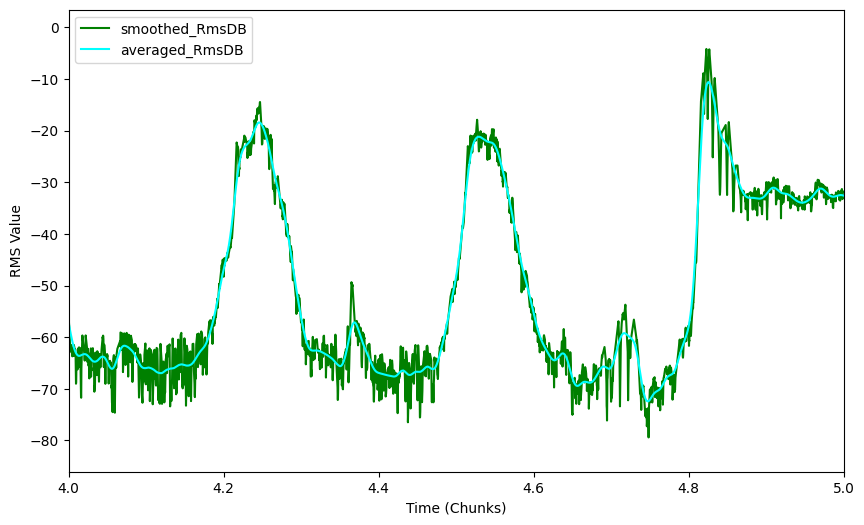

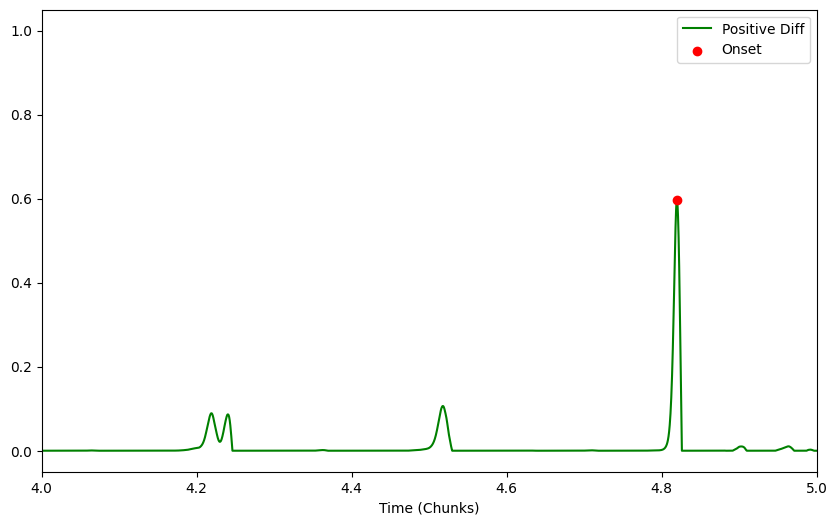

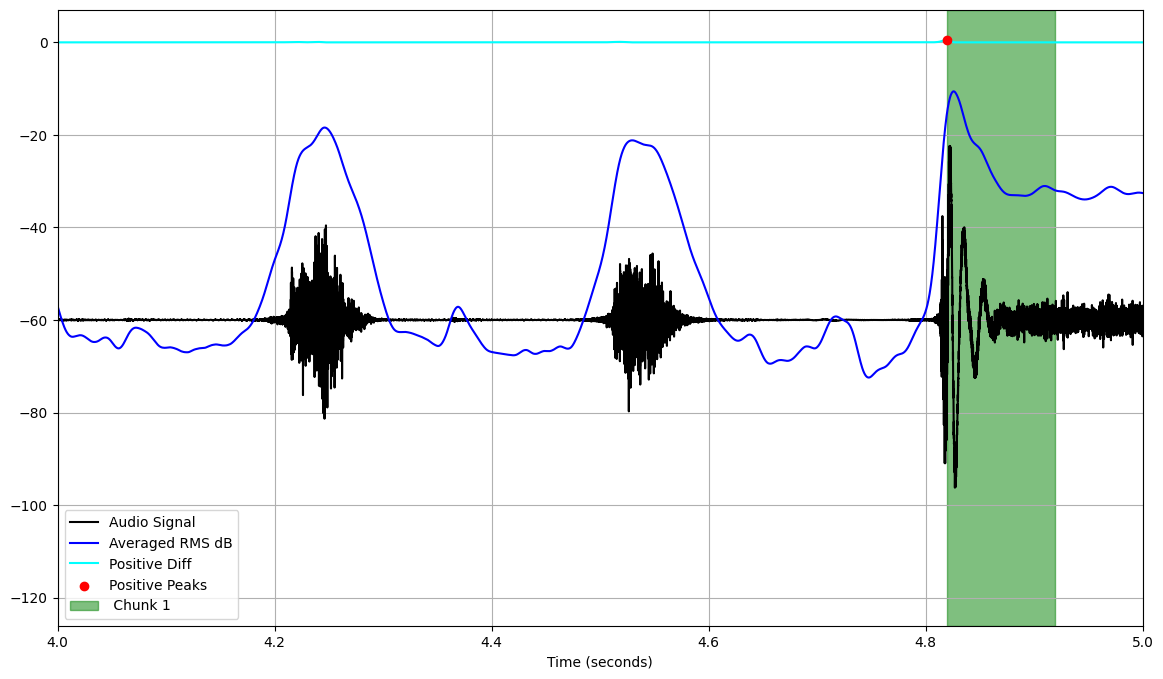

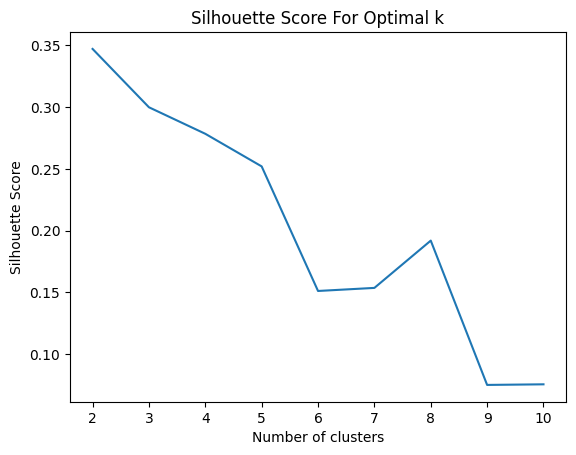

In [10]:
### Plotting RMS
plt.figure(figsize=(10, 6))
plt.plot(rms_time,smoothed_RmsDB, label='smoothed_RmsDB', color='green')
plt.plot(rms_time, averaged_RmsDB, label='averaged_RmsDB', color='cyan')
plt.xlabel('Time (Chunks)')
plt.ylabel('RMS Value')
plt.legend()
plt.xlim(PlotRange)
plt.show()

### Plotting Onset
plt.figure(figsize=(10, 6))
plt.plot(rms_time, postiveDiff, label='Positive Diff', color='green')
plt.scatter(rms_time[postivePeaks], postiveDiff[postivePeaks], color='red', label='Onset', zorder=5)
plt.xlabel('Time (Chunks)')
plt.legend()
plt.xlim(PlotRange)
plt.show() 

### Plotting Chunk
plt.figure(figsize=(14, 8))
plt.plot(time, (AudioArray/np.max(np.abs(AudioArray)) - 1) * 60, label='Audio Signal', color='black')
plt.plot(rms_time, averaged_RmsDB, label='Averaged RMS dB', color='blue')
plt.plot(rms_time, postiveDiff, label='Positive Diff', color='cyan')
plt.scatter(rms_time[postivePeaks], postiveDiff[postivePeaks], color='red', label='Positive Peaks', zorder=5)
colors = ['green', 'blue', 'red', 'orange','cyan']
for i, (start, end) in enumerate(Chunks):
    plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.5, label=f' Chunk {i+1}' if i == 0 else "")
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.xlim(PlotRange)
plt.show()

### Plotting Silhhouette
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()